# KS  

Kolmogorov-Smirnov metric (ks metric) is derived from K-S test. K-S test measures the distance between two plotted cumulative distribution functions (CDF).   
  
To use it as a metric for classification problem we see the distance of plotted CDF of target and non-target. It can be also defined as the maximum distance between TNR and FNR. [🔗](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)   
  
The model that produces the greatest amount of separability between target and non-target distribution would be considered the better model.  

![](assets/ks_ss.png)

## Why KS?  


- Scale-invariant. It measures how well predictions are ranked, rather than their absolute values.

- Threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

- Although KS is a single metric. KS table / Gains Table can be used to take different actions for different bins. 

## Calculating KS

```{note}
The following steps can be also done with pandas 
```

In [1]:
# sample dataset and sample model

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# make sample dataset
X, y = make_classification(
    n_samples=1000, class_sep=0.3, random_state=0
)  # 1000 samples with 20 features

# split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# simple Logistic Model
model = LogisticRegression(random_state=23)
model.fit(X_train, y_train)

# predictions
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

print(
    X_train.shape,
    y_train.shape,
    y_train_pred.shape,
    X_test.shape,
    y_test.shape,
    y_test_pred.shape,
)

(670, 20) (670,) (670,) (330, 20) (330,) (330,)


Consider the following example, `y_test` represents true target values, here as 1s and 0s. and `y_test_pred` as prediction probabilities. 

In [2]:
y_test[:5], y_test_pred[:5]

(array([0, 0, 1, 0, 1]),
 array([0.3143867 , 0.13123316, 0.15998113, 0.35006658, 0.83034574]))

#### 1. 2D array with y_true and y_pred

In [3]:
ks_arr = np.dstack((y_test, y_test_pred))[0]  # dstack returns a 3D array with len(z-axis)=1

ks_arr[:5]  # view array

array([[0.        , 0.3143867 ],
       [0.        , 0.13123316],
       [1.        , 0.15998113],
       [0.        , 0.35006658],
       [1.        , 0.83034574]])

#### 2. sort the array with y_pred. [why stable?](https://stackoverflow.com/questions/1517793/what-is-stability-in-sorting-algorithms-and-why-is-it-important#:~:text=A%20stable%20sorting,key%2Dvalue%20pairs.)

In [4]:
ks_arr = ks_arr[np.argsort(ks_arr[:, 1], kind="stable")]

ks_arr[:5]

array([[0.        , 0.0355004 ],
       [0.        , 0.04975776],
       [0.        , 0.05752943],
       [1.        , 0.06790324],
       [0.        , 0.07714446]])

#### 3. get total counts of positives and negatives

In [5]:
# np.unique(y_test, return_counts=True) -> (array([0, 1]), array([158, 172]))
y_true_counts = np.unique(y_test, return_counts=True)[1]

N = y_true_counts[0]
P = y_true_counts[1]

print(N, P)

158 172


#### 4. cumilative rates - cumilative sum by counts 

In [6]:
cs_N = ((1 - ks_arr[:, 0]).cumsum() / N) * 100 # tnr
cs_P = ((ks_arr[:, 0]).cumsum() / P) * 100 # fnr 

cs_N[:5], cs_P[:5]

(array([0.63291139, 1.26582278, 1.89873418, 1.89873418, 2.53164557]),
 array([0.        , 0.        , 0.        , 0.58139535, 0.58139535]))

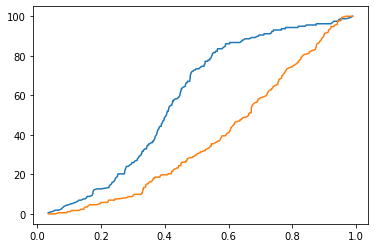

In [7]:
# plot cs_N and cs_P
fig, ax = plt.subplots(1, 1)
ax.plot(ks_arr[:, 1], cs_N)  # x-axis as y_pred
ax.plot(ks_arr[:, 1], cs_P)
plt.show()

#### 5. cumilative difference

In [8]:
cs_diff = np.abs(cs_N - cs_P)

cs_diff[:5]

array([0.63291139, 1.26582278, 1.89873418, 1.31733883, 1.95025022])

In [9]:
ks = cs_diff.max()

ks

46.916396820724174

####  Plotting KS

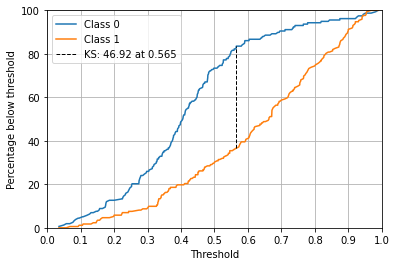

In [10]:
fig, ax = plt.subplots(1, 1)
# plot cumilative percent
ax.plot(ks_arr[:, 1], cs_N, label="Class 0")
ax.plot(ks_arr[:, 1], cs_P, label="Class 1")

# plot max seperation
ks_threshold = ks_arr[cs_diff.argmax(), 1]
ax.axvline(
    x=ks_threshold,
    ymin=sorted([cs_P[cs_diff.argmax()] / 100, cs_N[cs_diff.argmax()] / 100])[0],
    ymax=sorted([cs_P[cs_diff.argmax()] / 100, cs_N[cs_diff.argmax()] / 100])[1],
    c="black",
    linewidth=1,
    linestyle="--",
    label=f"KS: {ks.round(2)} at {ks_threshold.round(3)}",
)

# plot settings
ax.set_xlim([0, 1])
ax.set_ylim([0, 100])
ax.set_xlabel("Threshold")
ax.set_ylabel("Percentage below threshold")
ax.set_xticks(np.linspace(0, 1, 11))
ax.grid()
ax.legend()

plt.show()

## AUC and KS

There is a strong relationship between AUC and KS.

In [12]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

(((tpr-fpr).max())*100).round(2), ks.round(2)

(46.92, 46.92)

Explore [this Streamlit App](https://share.streamlit.io/nottherealsanta/mlogs/main/mlogs/apps/auc_ks.py) to understand more about the relationship between them. Also refer to [Youden's J statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic).

## KS Table 

#### 1. bin

In [14]:
# dataframe with y_true and y_pred
df = pd.DataFrame()
df["score"] = y_test_pred
# one hot encoding the dependent variable
df["class_n"] = 1 - y_test
df["class_p"] = y_test

# decile bins of prediction scores after ordering them
df["bin"] = pd.qcut(df.score.rank(method="first"), 10, labels=list(range(0, 10, 1)))

df.head()

,score,class_n,class_p,bin
0,0.314387,1,0,1
1,0.131233,1,0,0
2,0.159981,0,1,0
3,0.350067,1,0,2
4,0.830346,0,1,8


#### 2. target distribution

In [17]:
grouped = df.groupby("bin", as_index=False)

ks_table = pd.DataFrame()
ks_table["min_score"] = grouped.min().score
ks_table["max_score"] = grouped.max().score
ks_table["n_class_n"] = grouped.sum().class_n
ks_table["n_class_p"] = grouped.sum().class_p
ks_table["n_total"] = ks_table.n_class_n + ks_table.n_class_p

ks_table

,min_score,max_score,n_class_n,n_class_p,n_total
0,0.035500,0.224967,21,12,33
1,0.226262,0.327676,27,6,33
2,0.328646,0.377685,19,14,33
3,0.381554,0.437930,25,8,33
4,0.442221,0.491976,23,10,33
5,0.495512,0.575724,17,16,33
6,0.577944,0.671211,9,24,33
7,0.671344,0.757899,6,27,33
8,0.765076,0.874251,4,29,33
9,0.874542,0.988560,7,26,33


<AxesSubplot:>

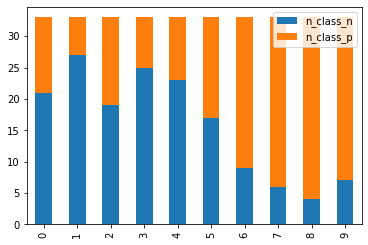

In [18]:
ks_table[
    [
        "n_class_n",
        "n_class_p",
    ]
].plot.bar(stacked=True)

The graph above show the difference in classification for each decicles. 

```{note}
This difference varies depending on performance.
```{list-table}
:header-rows: 1

* - KS 25
  - KS 50
  - KS 75
* - ![alt](assets/ks_25.png) 
  - ![alt](assets/ks_50.png)
  - ![alt](assets/ks_75.png)
```
```

#### 3. cumulative difference 

In [21]:
count_class_n = df.class_n.sum()
count_class_p = df.class_p.sum()

ks_table["%_class_n"] = (ks_table.n_class_n / count_class_n) * 100
ks_table["%_class_p"] = (ks_table.n_class_p / count_class_p) * 100

ks_table["cs_class_n"] = (ks_table.n_class_n / count_class_n).cumsum() * 100
ks_table["cs_class_p"] = (ks_table.n_class_p / count_class_p).cumsum() * 100

ks_table["cs_diff"] = np.abs(ks_table["cs_class_n"] - ks_table["cs_class_p"])
ks_table.style.format(
    "{:.1f}%", subset=["%_class_n", "%_class_p", "cs_class_n", "cs_class_p", "cs_diff"]
)

,min_score,max_score,n_class_n,n_class_p,n_total,%_class_n,%_class_p,cs_class_n,cs_class_p,cs_diff
0,0.035500,0.224967,21,12,33,13.3%,7.0%,13.3%,7.0%,6.3%
1,0.226262,0.327676,27,6,33,17.1%,3.5%,30.4%,10.5%,19.9%
2,0.328646,0.377685,19,14,33,12.0%,8.1%,42.4%,18.6%,23.8%
3,0.381554,0.437930,25,8,33,15.8%,4.7%,58.2%,23.3%,35.0%
4,0.442221,0.491976,23,10,33,14.6%,5.8%,72.8%,29.1%,43.7%
5,0.495512,0.575724,17,16,33,10.8%,9.3%,83.5%,38.4%,45.2%
6,0.577944,0.671211,9,24,33,5.7%,14.0%,89.2%,52.3%,36.9%
7,0.671344,0.757899,6,27,33,3.8%,15.7%,93.0%,68.0%,25.0%
8,0.765076,0.874251,4,29,33,2.5%,16.9%,95.6%,84.9%,10.7%
9,0.874542,0.988560,7,26,33,4.4%,15.1%,100.0%,100.0%,0.0%


`%_class_n` for 0th bin is 21 / total number of class_n.   
`cs_class_n` is the same but cumulatively summed.  
`cs_diff` is the difference between `cs_class_n` and `cs_class_p`

#### 4. KS

KS is the max difference between cumulatively summed rate of target and cumulatively summed non-target. i.e. maximum value of `cs_diff`

In [22]:
ks = ks_table["cs_diff"].max()

print(f"KS = {round(ks,2)}")

KS = 45.17


### Plot Binned KS

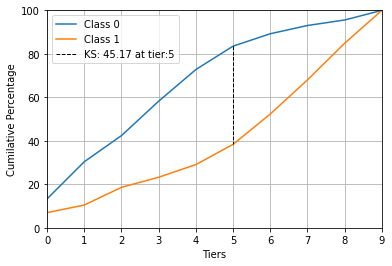

In [24]:
fig, ax = plt.subplots(1, 1)
ax.plot(ks_table["cs_class_n"], label="Class 0")
ax.plot(ks_table["cs_class_p"], label="Class 1")
ks_tier = ks_table["cs_diff"].idxmax()
ax.axvline(
    x=ks_tier,
    ymin=ks_table.loc[ks_tier, "cs_class_n"] / 100,
    ymax=ks_table.loc[ks_tier, "cs_class_p"] / 100,
    c="black",
    linewidth=1,
    linestyle="--",
    label=f"KS: {ks_table['cs_diff'].max().round(2)} at tier:{ks_tier}",
)
ax.set_xlim([0, 9])
ax.set_ylim([0, 100])
ax.set_xlabel("Tiers")
ax.set_ylabel("Cumilative Percentage")
ax.set_xticks(ks_table.index)
ax.grid()
ax.legend()
plt.show()

```{note}
Binned KS are useful when you intent to have different actions for differnt bins. For example in the case of credit scoring you might give different APRs to customers falling in different bins. 
```